<hr>
<center> Learning Element for Control Systems - Autumn Semester 2023 <br>
<b> Learning Element 1 </b> <br>
Prof. Dr. Florian Dörfler <br>
Automatic Control Laboratory, ETH Zurich </center>
<hr>

In this notebook, you will find different code fragments to complete Learning Element 1. <b>

<!-- <blockquote> -->
<b>Activity:</b> Execute the code cells below so that the necessary libraries get imported.
<!-- </blockquote> -->

In [7]:
import numpy as np # the standard library for numerics, vectors, matrices
import control as ct # the standard library for basic operations for analysis and design of feedback control systems
import matplotlib.pyplot as plt # a comprehensive library for creating static, animated, and interactive visualizations
import sympy as sp # the standard library for symbolic mathematical computations

<br>

<b> Code fragment for linearization </b>

In [8]:
# define symbolic variables
x, y, z, xdot, ydot, zdot, phi, theta, psi, p, q, r = sp.symbols('x, y, z, xdot, ydot, zdot, phi, theta, psi, p, q, r')
u1,u2,u3,u4, = sp.symbols('u1, u2, u3, u4')
m, g, Ix, Iy, Iz, kx, ky, kz, kp, kq, kr = sp.symbols('m, g, Ix, Iy, Iz, kx, ky, kz, kp, kq, kr')
zd, psid = sp.symbols('zd, psid')
deltaz, deltapsi, deltau1 = sp.symbols('deltaz, deltapsi, deltau1')

#  define symbolic state, input & equilibrium vector

states = sp.Array([[x,y,deltaz,xdot,ydot,zdot,phi,theta,psi,p,q,r]])
inputs = sp.Array([[deltau1,u2,u3,u4]])
equilibrium = sp.Array([[0,0,0,0,0,0,0,0,0,0,0,0]])

#nonlinear model
xddot = 1/m*((sp.cos(phi)*sp.sin(theta)*sp.cos(psi)+sp.sin(phi)*sp.sin(psi))*u1-kx*xdot)
yddot = 1/m*((sp.cos(phi)*sp.sin(theta)*sp.sin(psi)-sp.sin(phi)*sp.cos(psi))*u1-ky*ydot)
zddot = 1/m*(sp.cos(phi)*sp.cos(theta)*u1-m*g-kz*zdot)
pdot = 1/Ix*((Iy-Iz)*q*r+u2-kp*p)
qdot = 1/Iy*((Iz-Ix)*p*r+u3-kq*q)
rdot = 1/Iz*((Ix-Iy)*p*q+u4-kr*r)
dangledot=sp.Matrix([
                    [1,sp.sin(phi)*sp.tan(theta),sp.cos(phi)*sp.tan(theta)],
                    [0,sp.cos(phi),-sp.sin(phi)],
                    [0,sp.sin(phi)/sp.cos(theta),sp.cos(phi)/sp.cos(theta)]
                    ])
pqr=sp.Matrix([p,q,r])
phidot=dangledot.row(0).dot(pqr)
thetadot=dangledot.row(1).dot(pqr)
psidot=dangledot.row(2).dot(pqr)
drone = sp.Matrix([xdot,ydot,zdot,xddot,yddot,zddot,phidot,thetadot,psidot,pdot,qdot,rdot])

#compute symbolic state-space matrices

drone=drone.subs([(z,deltaz+zd),(psi,deltapsi+psid),(u1,deltau1+m*g)])
A=drone.jacobian([x,y,deltaz,xdot,ydot,zdot,phi,theta,deltapsi,p,q,r]).subs([(x,0),(y,0),(deltaz,0),(xdot,0),(ydot,0),(zdot,0),(phi,0),(theta,0),(deltapsi,0),(p,0),(q,0),(r,0),(deltau1,0),(u2,0),(u3,0),(u4,0)])
B=drone.jacobian([deltau1,u2,u3,u4]).subs([(x,0),(y,0),(deltaz,0),(xdot,0),(ydot,0),(zdot,0),(phi,0),(theta,0),(deltapsi,0),(p,0),(q,0),(r,0),(deltau1,0),(u2,0),(u3,0),(u4,0)])
print(A)
print(B)

#compute numeric state-space matrices with dtype float
Asym=A.copy()
Bsym=B.copy()
A=A.subs([(m,0.03),(g,9.81),(Ix,1.5e-5),(Iy,1.5e-5),(Iz,3e-5),(zd,2),(psid,np.pi/4),(kx,4.5e-3),(ky,4.5e-3),(kz,4.5e-3),(kp,4.5e-4),(kq,4.5e-4),(kr,4.5e-4)])
B=B.subs([(m,0.03),(g,9.81),(Ix,1.5e-5),(Iy,1.5e-5),(Iz,3e-5),(zd,2),(psid,np.pi/4),(kx,4.5e-3),(ky,4.5e-3),(kz,4.5e-3),(kp,4.5e-4),(kq,4.5e-4),(kr,4.5e-4)])
# print system matrices A, B
np.set_printoptions(precision=4,suppress=True)
print('The system matrix A is \n',A)
print('The system matrix B is \n',B)

Matrix([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, -kx/m, 0, 0, g*sin(psid), g*cos(psid), 0, 0, 0, 0], [0, 0, 0, 0, -ky/m, 0, -g*cos(psid), g*sin(psid), 0, 0, 0, 0], [0, 0, 0, 0, 0, -kz/m, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, -kp/Ix, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -kq/Iy, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -kr/Iz]])
Matrix([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [1/m, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 1/Ix, 0, 0], [0, 0, 1/Iy, 0], [0, 0, 0, 1/Iz]])
The system matrix A is 
 Matrix([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, -0.150000000000000, 0, 0, 6.93671752344003, 6.93671752344003, 0, 0, 0, 0], [0, 0, 0, 0, -0.150000000000000, 0, -6.93671752

<br>

<b> Code fragment for calculating transfer functions </b>

In [9]:
#create state-space system & transfer function
C=sp.Matrix([[1,0,0,0,0,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,1,0,0,0]])
D=sp.Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
#establish matrix block for deltaU1 and deltaz
tmpB=B[:,0]
tmpC=C[2,:]
sys_u12z_ss = ct.ss(A,tmpB,tmpC,[[0]])
sys_u12z_tf = ct.ss2tf(sys_u12z_ss)
print(sys_u12z_tf)
#establish matrix block for U4 and deltapsi
tmpB=B[:,3]
tmpC=C[3,:]
sys_u42psi_ss = ct.ss(A,tmpB,tmpC,[[0]])
sys_u42psi_tf = ct.ss2tf(sys_u42psi_ss)
print(sys_u42psi_tf)




   33.33
------------
s^2 + 0.15 s


3.333e+04
----------
s^2 + 15 s



<br>

<b> Code fragment for stability analysis </b>

In [10]:
#compute eigenvalues
tmp=np.array(A,dtype=float)
ev=np.linalg.eigvals(tmp)
print(ev)


#compute Jordan form
#Hint: To compute the Jordan form of the matrix M, use the command 'M.jordan_form()', which can only be applied if M is a Sympy matrix.
jordan=sp.Matrix(A).jordan_form()
print(jordan)

[  0.     0.     0.    -0.15  -0.15  -0.15   0.     0.     0.   -30.
 -30.   -15.  ]
[Matrix([
[-0.000258206496312676, -0.000258206496312676,                   0, -6.66666666666667,                 0,                 0,  46.2447834896002,                 0, 46.2447834896002,                0,   0,   0],
[ 0.000258206496312676, -0.000258206496312676,                   0,                 0, -6.66666666666667,                 0, -46.2447834896002,                 0, 46.2447834896002,                0,   0,   0],
[                    0,                     0,                   0,                 0,                 0, -6.66666666666667,                 0,                 0,                0,                0, 1.0,   0],
[  0.00774619488938027,   0.00774619488938027,                   0,               1.0,                 0,                 0,                 0,  46.2447834896002,                0, 46.2447834896002,   0,   0],
[ -0.00774619488938027,   0.00774619488938027,                   

<br>

<b> Code fragment for forced responses </b>


3.333e+04
----------
s^2 + 15 s

The final value of the the heading steady state error in the impulsive input case is 0.11111


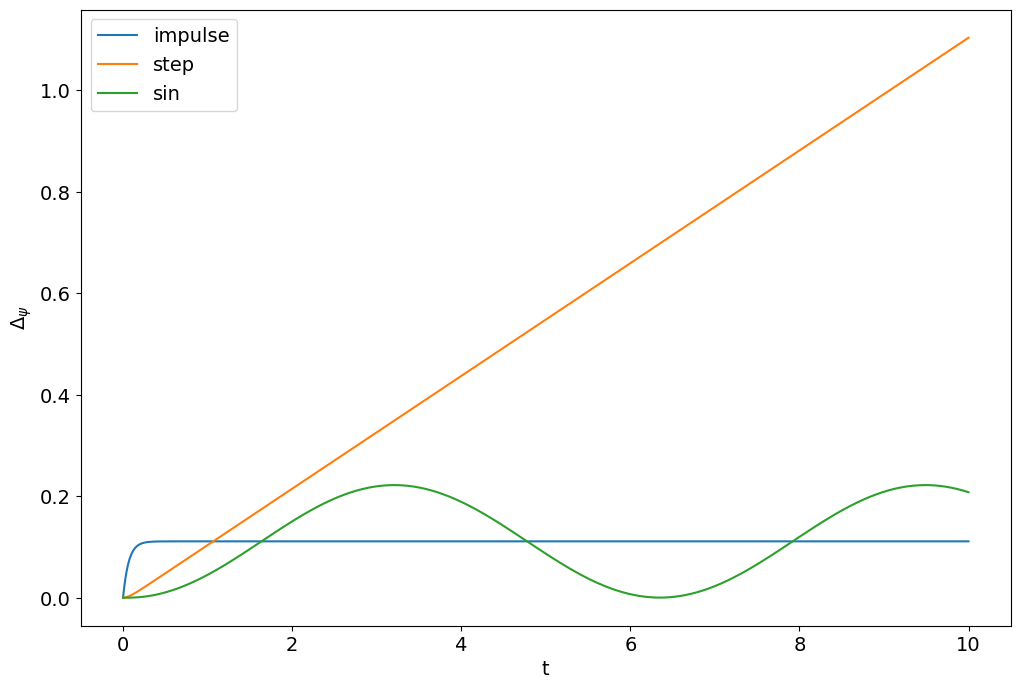

In [11]:
#extracting the heading dynamics
A_heading = A
B_heading=B[:,3]
C_heading=C[3,:]
D_heading = [[0]]
sys_heading = ct.ss2tf(A_heading,B_heading,C_heading,D_heading)
print(sys_heading)


#plot impulse response
t=np.linspace(0,10,1000)
t_impulse,y_impulse=ct.impulse_response(sys_heading,T=t)
y_impulse*=5e-5
plt.figure(figsize=(12,8))
plt.rcParams['font.size']=14
plt.plot(t_impulse,y_impulse,label="impulse")

#plot step response
t_step,y_step = ct.step_response(sys_heading,T=t)
y_step*=5e-5
plt.plot(t_step,y_step,label="step")

#plot sinusoidal response
u=np.sin(t)*5e-5
t_sin,y_sin = ct.forced_response(sys_heading,t,U=u)
plt.plot(t_sin,y_sin,label="sin")

plt.xlabel("t")
plt.ylabel("$\Delta_\psi$")
plt.legend(loc="upper left")

# show the final value of the impulse response
print('The final value of the the heading steady state error in the impulsive input case is %.5f' %(y_impulse[-1]))

<br>

<b> Code fragment for proportional control </b>


   33.33
------------
s^2 + 0.15 s


 When the gain k is 0.000, the results are as follows.

        33.33
---------------------
s^2 + 0.15 s + 0.1667


 When the gain k is 0.005, the results are as follows.

        33.33
---------------------
s^2 + 0.15 s - 0.1667


 When the gain k is -0.005, the results are as follows.


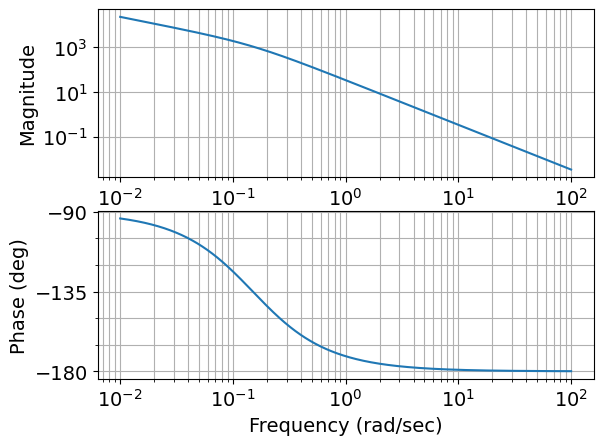

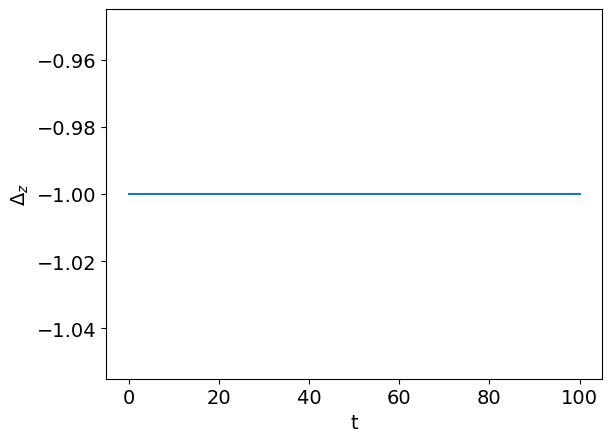

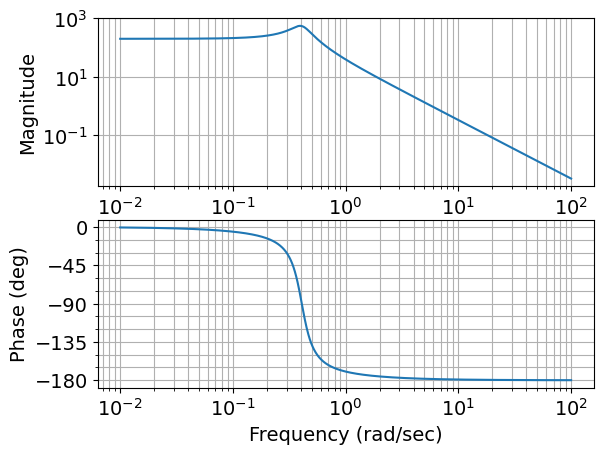

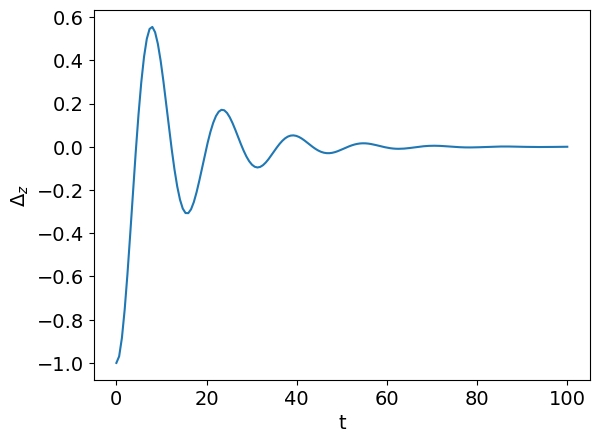

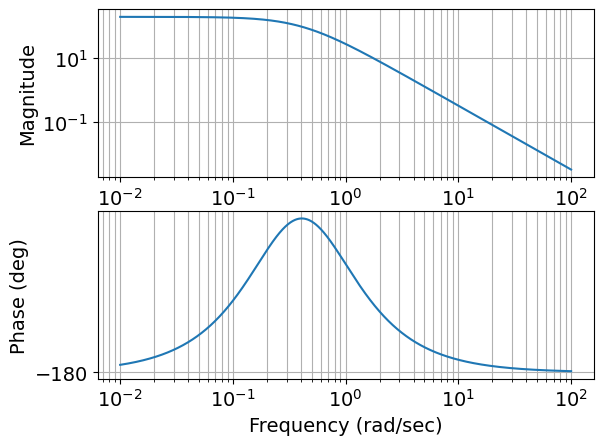

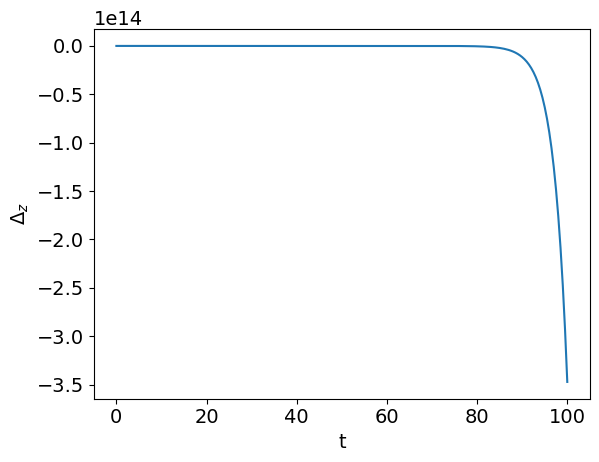

In [12]:
def proportional_control(A,B,C,D,k):
    # A,B,C,D: system matrices; k: feedback gain
    #extracting the altitude dynamics

    #-------------#
    #A_altitude = np.array([[0,1],[-k/0.03,-0.15]])
    #B_altitude = np.array([[0],[1/0.03]])
    #C_altitude = np.array([[1,0]])
    #-------------#
    
    tmp=np.zeros((12,12),dtype=float)
    tmp[5,2]=-k/0.03
    A_altitude = A+tmp
    B_altitude = B[:,0]
    C_altitude = C[2,:]
    gain = k
    sys_altitude=ct.ss(A_altitude,B_altitude,C_altitude,[[0]])
    tmp=ct.ss2tf(sys_altitude)
    print(tmp)
    


    print("\n When the gain k is %.3f, the results are as follows." %(k))
        
    # Bode plot
    fig1=plt.figure()
    ct.bode_plot(sys_altitude)
 
    
    # initial condition response

    #-------------#
    #t_pc, y_pc = ct.initial_response(sys_altitude,T=100,X0=[-1,0])
    #-------------#


    t_pc, y_pc = ct.initial_response(sys_altitude,T=100,X0=[0,0,-1,0,0,0,0,0,0,0,0,0])
    fig2=plt.figure()
    plt.plot(t_pc,y_pc)
    plt.xlabel("t")
    plt.ylabel("$\Delta_z$")
 

    
# normal case 
proportional_control(A,B,C,D,0)
# choose a stabilizing gain
proportional_control(A,B,C,D,0.005)
# choose a non-stabilizing gain
proportional_control(A,B,C,D,-0.005)